## Import Package

In [30]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import cv2

## Load MNIST dataset

In [31]:
# load data from tensorflow framework
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Stack train data and test data to form single array 
mnist_data = np.vstack([x_train, x_test])

# Horizontal stacking labels of train and test set
mnist_labels = np.hstack([y_train, y_test])

mnist_data.shape, mnist_labels.shape

((70000, 28, 28), (70000,))

## Load A-Z letter dataset

In [33]:
def load_az_dataset(datasetPath):
    df = pd.read_csv(datasetPath)
    x = df.drop(df.columns[0],axis=1) # Droping the label column
    y = df.iloc[:,0].copy() # Copying the label column

    # Creating numpy array
    x = np.array(x, dtype='float32').reshape(-1, 28 , 28)
    y = np.array(y, dtype="int")
    
    return (x, y)

In [34]:
az_data, az_labels = load_az_dataset('./archive/A_Z Handwritten Data/A_Z Handwritten Data.csv')
az_data.shape, az_labels.shape

((372450, 28, 28), (372450,))

## Merge two datset

In [58]:
# the MNIST dataset occupies the labels 0-9, 
# so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 
az_labels += 10

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([az_data, mnist_data])
labels = np.hstack([az_labels, mnist_labels])

data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

## Explore dataset

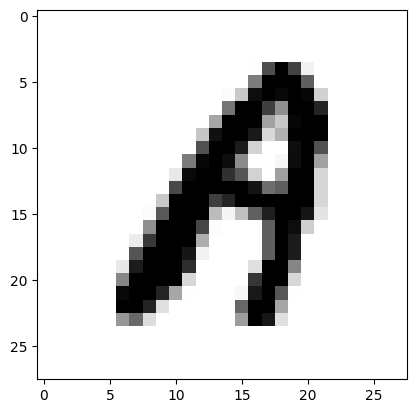

In [57]:
sample_data = az_data[0]
sample_image = sample_data
plt.imshow(sample_image,cmap=matplotlib.cm.binary,interpolation="nearest")

<BarContainer object of 36 artists>

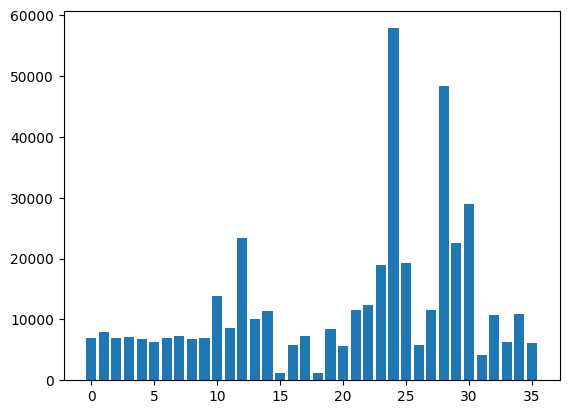

In [56]:
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)

## Train test split

In [59]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size = 0.2,
                                                 random_state = 66)
x_train.shape,x_test.shape, y_train.shape, y_test.shape

((353960, 28, 28, 1), (88490, 28, 28, 1), (353960,), (88490,))

## Train model

In [37]:
from tensorflow import keras
from keras import layers

In [38]:
num_classes = 36
input_shape = (28, 28, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [39]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
2213/2213 [==============================] - 126s 56ms/step - loss: 0.3484 - accuracy: 0.9015 - val_loss: 0.1513 - val_accuracy: 0.9580
Epoch 2/15
2213/2213 [==============================] - 125s 57ms/step - loss: 0.1733 - accuracy: 0.9499 - val_loss: 0.1191 - val_accuracy: 0.9671
Epoch 3/15
2213/2213 [==============================] - 129s 58ms/step - loss: 0.1457 - accuracy: 0.9581 - val_loss: 0.1065 - val_accuracy: 0.9698
Epoch 4/15
2213/2213 [==============================] - 135s 61ms/step - loss: 0.1298 - accuracy: 0.9622 - val_loss: 0.1003 - val_accuracy: 0.9715
Epoch 5/15
2213/2213 [==============================] - 139s 63ms/step - loss: 0.1191 - accuracy: 0.9653 - val_loss: 0.0907 - val_accuracy: 0.9747
Epoch 6/15
2213/2213 [==============================] - 137s 62ms/step - loss: 0.1105 - accuracy: 0.9673 - val_loss: 0.0820 - val_accuracy: 0.9775
Epoch 7/15
2213/2213 [==============================] - 151s 68ms/step - loss: 0.1043 - accuracy: 0.9691 - val_loss: 0

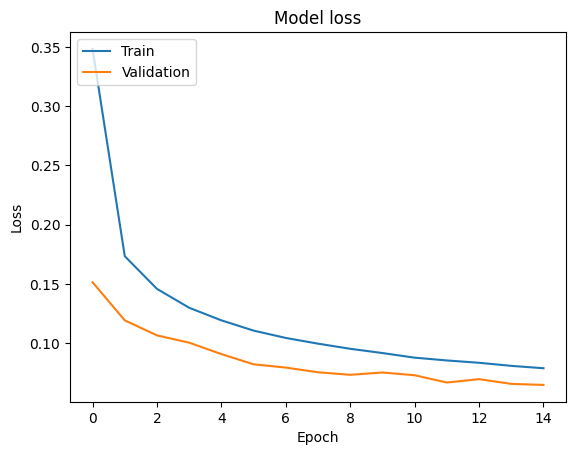

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
y_pred = model.predict(x_test)
Y_test = np.array([np.argmax(p) for p in y_test])
Y_pred = np.array([np.argmax(p) for p in y_pred])
cf_matrix  = confusion_matrix(Y_test ,Y_pred)

2766/2766 [==============================] - 29s 10ms/step


<Axes: >

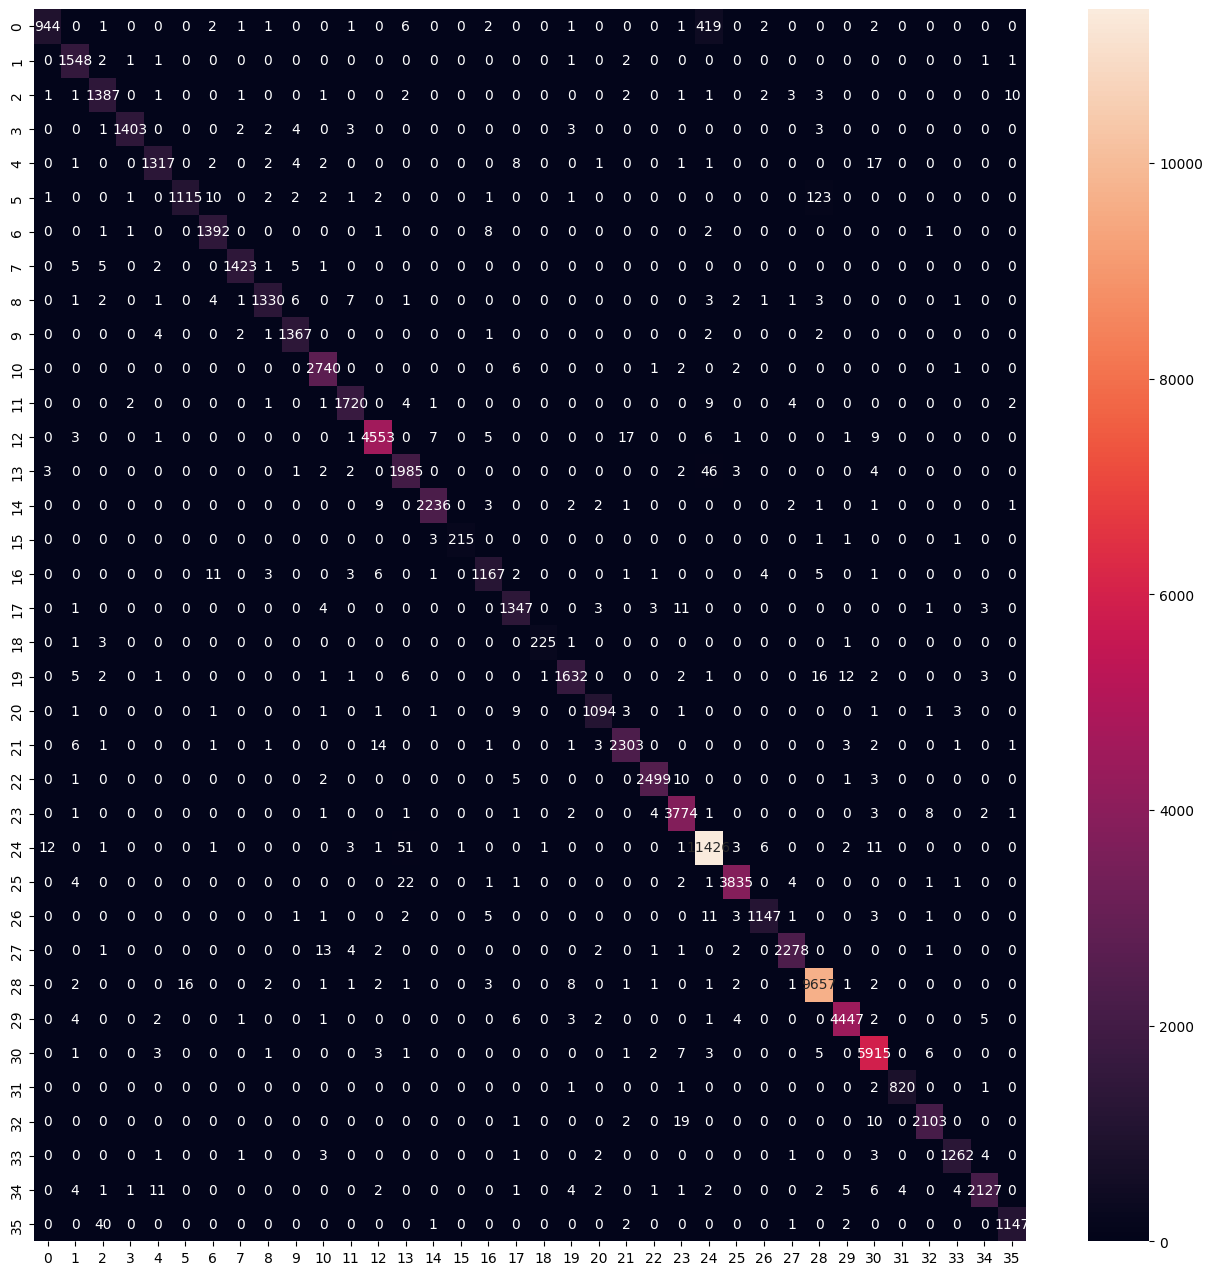

In [42]:
import seaborn as sns
plt.figure(figsize = (16,16))
heatmap = sns.heatmap(cf_matrix, 
                      annot=True,
                       fmt="d")
figure = heatmap.get_figure()    
figure.savefig('heatmap.png', dpi=400)
heatmap

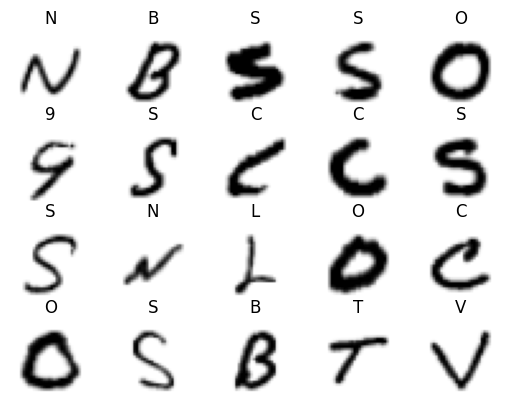

In [47]:
from numpy import random
for i in range(1,21):
    a = random.randint(len(x_test))
    img = x_test[a]
    img_res = img
    plt.subplot(4,5,i)
    plt.imshow(img_res, cmap='binary')
    plt.axis('off')
    pred = np.argmax(y_test[a])
    if pred >= 10:
        pred = chr(pred - 10 + ord('A')) 
    else:
        pred = chr(pred + ord('0'))
    plt.title(pred)
plt.show()

In [45]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

print("")

score = model.evaluate(x_train, y_train)
print("Train loss:", score[0])
print("Train accuracy:", score[1])

2766/2766 [==============================] - 46s 17ms/step - loss: 0.0651 - accuracy: 0.9818
Test loss: 0.06507232040166855
Test accuracy: 0.9818058609962463

11062/11062 [==============================] - 168s 15ms/step - loss: 0.0482 - accuracy: 0.9858
Train loss: 0.04816386103630066
Train accuracy: 0.9857752323150635


In [48]:
model.save('model_2.h5')

## Reference
* https://www.kaggle.com/code/medali1992/resnet50d-train-mnist-a-z